# Sentinel images

Sentinel image processing will be divided into 3 stages: 
>- download images via python
>- preprocessing
>- image processing

## Download images

Downloading Sentinal images requires:
- product type selection: `S2`
- filtering images due to cloudiness: `cloudcoverpercentage=(0, 20)`
- definition of the area of interest

**Area of interest**
>- `geopy` module - get location by country, city
>- `utm` module - conversion of geographic coordinates to the utm system and vice versa
>- `geojson` - notation of coordinates in geojson format,which is used to create the polygon object by the shapely module
>- `shapely` - creating polygon geometry - which will be used to visualize and trim the area of interest and to define the area of interest by SentinelHub 
>- `ipyleaflet` - display the map 


## Preprocessing

>- Unzip Sentinel-2 data
>- Preparation of the `polygon`
>- Channel selection
>- Resampling
>- Trimming (clipping) images]
>- Save data

## New environment 

Create a new environment to handle Sentinel images - e.g. `sen`. Necessary packages:
>- numpy, pandas, matplotlib
>- rasterio
> -geopy, geojson, shapely
>- sentinelsat
>- utm
>- ipyleaflet

In [1]:
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import geojson
#from shapely.geometry import shape
from shapely import geometry
from sentinelsat import SentinelAPI
from datetime import date
import utm
from ipyleaflet import Map, Marker, basemaps, basemap_to_tiles
from ipyleaflet import Polygon as ipylPolygon

# Download images
## Geopy

In [2]:
address={'country':'Poland','city':'Swornegacie'}  # my cities
geolocator = Nominatim(user_agent="Pio")
location = geolocator.geocode(address)
type(location)

geopy.location.Location

In [3]:
location.longitude, location.latitude

(17.4991394, 53.8604117)

In [4]:
p = location.point

## Utm

In [5]:
utm.from_latlon(location.latitude, location.longitude)

(664349.1620839138, 5970886.588540567, 33, 'U')

In [6]:
x,y,zone, zone_letter = utm.from_latlon(location.latitude, location.longitude)
x,y

(664349.1620839138, 5970886.588540567)

In [7]:
offset = 15*1000
upl = (x-offset, y+offset)
bol = (x-offset, y-offset)

upr = (x+offset, y+offset)
bor = (x+offset, y-offset)

utmPoints = [upl,upr,bor,bol]
utmPoints

[(649349.1620839138, 5985886.588540567),
 (679349.1620839138, 5985886.588540567),
 (679349.1620839138, 5955886.588540567),
 (649349.1620839138, 5955886.588540567)]

In [8]:
poly = []
for p in utmPoints:
    lat, lon = utm.to_latlon(*p,zone,zone_letter)
    poly.append((lat,lon))
poly.append(poly[0])
poly = [poly]
poly

[[(53.99965710756386, 17.278583044505567),
  (53.99011521095917, 17.735758024374025),
  (53.720776757226965, 17.71823497713635),
  (53.73022549168856, 17.263981555126215),
  (53.99965710756386, 17.278583044505567)]]

In [9]:
poly = []
for p in utmPoints:
    lat, lon = utm.to_latlon(*p,zone,zone_letter)
    poly.append((lon,lat))
poly.append(poly[0])
poly = [poly]
poly

[[(17.278583044505567, 53.99965710756386),
  (17.735758024374025, 53.99011521095917),
  (17.71823497713635, 53.720776757226965),
  (17.263981555126215, 53.73022549168856),
  (17.278583044505567, 53.99965710756386)]]

## Geojson

In [10]:
# convet polygon coordinates to geojson format
polyGeojson = geojson.Polygon(poly)
print(polyGeojson,'\n\n',type(polyGeojson),'\n')

{"coordinates": [[[17.278583, 53.999657], [17.735758, 53.990115], [17.718235, 53.720777], [17.263982, 53.730225], [17.278583, 53.999657]]], "type": "Polygon"} 

 <class 'geojson.geometry.Polygon'> 



## Shapely

type: <class 'shapely.geometry.polygon.Polygon'>



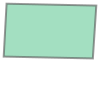

In [11]:
polyShapely = geometry.shape(polyGeojson)
print(f'type: {type(polyShapely)}\n')
polyShapely

In [26]:
polyShapely.to_wkt()

'POLYGON ((17.2785830000000011 53.9996569999999991, 17.7357580000000006 53.9901150000000030, 17.7182350000000000 53.7207769999999982, 17.2639819999999986 53.7302249999999972, 17.2785830000000011 53.9996569999999991))'

polyShapely = geometry.asPolygon(utmPoints)
print(f'type: {type(polyShapely)}\n')
polyShapely

## ipyleaflet

In [29]:
latlon = (location.latitude,location.longitude)
#latlon = (location.longitude,location.latitude)

m = Map(
    basemap=basemap_to_tiles(basemaps.OpenTopoMap, "2017-08-08"),
    center=(latlon[0],latlon[1]),
    zoom=10
)

m.add_layer(Marker(location=latlon))
area = ipylPolygon(locations=poly,color='red',fill_opacity= 0.1,weight=2)
m.add_layer(area)
m

Map(center=[53.8604117, 17.4991394], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

In [14]:
from IPython import display

In [15]:
location.longitude, location.latitude

(17.4991394, 53.8604117)

In [16]:
api = SentinelAPI('Puchatek', '!scihub.copernicus.eu!', 'https://scihub.copernicus.eu/dhus')

In [17]:
products = api.query(polyShapely,
                     date=('20210315', '20210410'),
                     platformname='Sentinel-2',
                     cloudcoverpercentage=(0, 20))

In [18]:
df = api.to_dataframe(products)
df

,title,link,link_alternative,link_icon,summary,ondemand,ingestiondate,beginposition,endposition,generationdate,...,platformname,size,datastripidentifier,granuleidentifier,level1cpdiidentifier,uuid,datatakesensingstart,sensoroperationalmode,tileid,hv_order_tileid
f91cebb6-90a8-4677-ac1f-5129ee6a9bac,S2A_MSIL2A_20210331T100021_N0300_R122_T33UXV_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-03-31T10:00:21.024Z, Instrument: MS...",false,2021-03-31 19:48:08.303,2021-03-31 10:00:21.024,2021-03-31 10:00:21.024,2021-03-31 12:52:12,...,Sentinel-2,1.07 GB,S2A_OPER_MSI_L2A_DS_VGS4_20210331T125212_S2021...,S2A_OPER_MSI_L2A_TL_VGS4_20210331T125212_A0301...,S2A_OPER_MSI_L1C_TL_VGS4_20210331T113321_A0301...,f91cebb6-90a8-4677-ac1f-5129ee6a9bac,NaT,NaN,NaN,NaN
488958c6-4976-40d4-a1e8-87bb2d05eb56,S2A_MSIL1C_20210331T100021_N0300_R122_T33UXV_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-03-31T10:00:21.024Z, Instrument: MS...",false,2021-03-31 15:37:16.793,2021-03-31 10:00:21.024,2021-03-31 10:00:21.024,2021-03-31 11:33:21,...,Sentinel-2,791.14 MB,S2A_OPER_MSI_L1C_DS_VGS4_20210331T113321_S2021...,S2A_OPER_MSI_L1C_TL_VGS4_20210331T113321_A0301...,S2A_OPER_MSI_L1C_TL_VGS4_20210331T113321_A0301...,488958c6-4976-40d4-a1e8-87bb2d05eb56,2021-03-31 10:00:21.024,INS-NOBS,33UXV,UV33X
18ecce27-2437-4f84-b0d2-fe6a9de25135,S2B_MSIL2A_20210326T100029_N0214_R122_T33UXV_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-03-26T10:00:29.024Z, Instrument: MS...",false,2021-03-26 19:24:30.966,2021-03-26 10:00:29.024,2021-03-26 10:00:29.024,2021-03-26 12:43:11,...,Sentinel-2,1.05 GB,S2B_OPER_MSI_L2A_DS_VGS4_20210326T124311_S2021...,S2B_OPER_MSI_L2A_TL_VGS4_20210326T124311_A0211...,S2B_OPER_MSI_L1C_TL_VGS4_20210326T111328_A0211...,18ecce27-2437-4f84-b0d2-fe6a9de25135,NaT,NaN,NaN,NaN
239ed32b-2c60-4fb0-8964-ef4c32dbc461,S2B_MSIL1C_20210326T100029_N0209_R122_T33UXV_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2021-03-26T10:00:29.024Z, Instrument: MS...",false,2021-03-26 15:36:54.844,2021-03-26 10:00:29.024,2021-03-26 10:00:29.024,2021-03-26 11:13:28,...,Sentinel-2,758.93 MB,S2B_OPER_MSI_L1C_DS_VGS4_20210326T111328_S2021...,S2B_OPER_MSI_L1C_TL_VGS4_20210326T111328_A0211...,S2B_OPER_MSI_L1C_TL_VGS4_20210326T111328_A0211...,239ed32b-2c60-4fb0-8964-ef4c32dbc461,2021-03-26 10:00:29.024,INS-NOBS,33UXV,UV33X


In [19]:
df.columns

Index(['title', 'link', 'link_alternative', 'link_icon', 'summary', 'ondemand',
       'ingestiondate', 'beginposition', 'endposition', 'generationdate',
       'orbitnumber', 'relativeorbitnumber', 'cloudcoverpercentage',
       'highprobacloudspercentage', 'mediumprobacloudspercentage',
       'notvegetatedpercentage', 'snowicepercentage', 'unclassifiedpercentage',
       'vegetationpercentage', 'waterpercentage', 'illuminationazimuthangle',
       'illuminationzenithangle', 'filename', 'gmlfootprint', 'format',
       'identifier', 'instrumentshortname', 'instrumentname', 'footprint',
       's2datatakeid', 'platformidentifier', 'orbitdirection',
       'platformserialidentifier', 'processingbaseline', 'processinglevel',
       'producttype', 'platformname', 'size', 'datastripidentifier',
       'granuleidentifier', 'level1cpdiidentifier', 'uuid',
       'datatakesensingstart', 'sensoroperationalmode', 'tileid',
       'hv_order_tileid'],
      dtype='object')

In [20]:
df.loc[:,['title','uuid','cloudcoverpercentage']]

,title,uuid,cloudcoverpercentage
f91cebb6-90a8-4677-ac1f-5129ee6a9bac,S2A_MSIL2A_20210331T100021_N0300_R122_T33UXV_2...,f91cebb6-90a8-4677-ac1f-5129ee6a9bac,0.540576
488958c6-4976-40d4-a1e8-87bb2d05eb56,S2A_MSIL1C_20210331T100021_N0300_R122_T33UXV_2...,488958c6-4976-40d4-a1e8-87bb2d05eb56,0.404700
18ecce27-2437-4f84-b0d2-fe6a9de25135,S2B_MSIL2A_20210326T100029_N0214_R122_T33UXV_2...,18ecce27-2437-4f84-b0d2-fe6a9de25135,8.609139
239ed32b-2c60-4fb0-8964-ef4c32dbc461,S2B_MSIL1C_20210326T100029_N0209_R122_T33UXV_2...,239ed32b-2c60-4fb0-8964-ef4c32dbc461,5.278300


In [21]:
%pwd

'/home/u1/22_dydaktyka/05imProc/rok2021'

In [22]:
df.index[2]

'18ecce27-2437-4f84-b0d2-fe6a9de25135'

In [23]:
uuid = df.index[2]
filename = df.loc[uuid,'filename']
print(f'uuid:\t\t{uuid}\nfilename:\t{filename}')

uuid:		18ecce27-2437-4f84-b0d2-fe6a9de25135
filename:	S2B_MSIL2A_20210326T100029_N0214_R122_T33UXV_20210326T124311.SAFE


```python
uuid = df.loc['86195c73-bbc5-41c1-ab83-8c2d6595b5e0','uuid']
filename = df.loc['86195c73-bbc5-41c1-ab83-8c2d6595b5e0','filename']
print(f'uuid:\t\t{uuid}\nfilename:\t{filename}')
```

In [25]:
api = SentinelAPI('galia1983', 'Ruda1983@', 'https://scihub.copernicus.eu/dhus')
dest = '/home/u1/22_dydaktyka/05imProc/img_test/'
api.download(uuid,dest)

Downloading:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

MD5 checksumming:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

{'id': '18ecce27-2437-4f84-b0d2-fe6a9de25135',
 'title': 'S2B_MSIL2A_20210326T100029_N0214_R122_T33UXV_20210326T124311',
 'size': 1129175233,
 'md5': '3f57cc4504fd065caa02db8b07974dd4',
 'date': datetime.datetime(2021, 3, 26, 10, 0, 29, 24000),
 'footprint': 'POLYGON((16.530701256365735 54.138373318280884,18.20926008487338 54.10530483528773,18.135320369204088 53.119880621881606,16.495379581512257 53.15178549855093,16.530701256365735 54.138373318280884))',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('18ecce27-2437-4f84-b0d2-fe6a9de25135')/$value",
 'Online': False,
 'Creation Date': datetime.datetime(2021, 3, 26, 19, 24, 30, 966000),
 'Ingestion Date': datetime.datetime(2021, 3, 26, 19, 24, 30, 966000),
 'quicklook_url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('18ecce27-2437-4f84-b0d2-fe6a9de25135')/Products('Quicklook')/$value",
 'path': '/home/u1/22_dydaktyka/05imProc/img_test/S2B_MSIL2A_20210326T100029_N0214_R122_T33UXV_20210326T124311.zip',
 'downloaded

```python
dest = '/home/u1/22_dydaktyka/05imProc/img_test/'
api.download(uuid,dest)
```